In [1]:
import pandas as pd
import numpy as np

import re
import string

import spacy
import nltk

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
nltk.download('stopwords') # run this one time

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
review_data= pd.read_excel('/kaggle/input/dental-book-reviews/Cleaned_Synthetic_No_Special_Characters.xlsx')
print(review_data.head(5))

   Book ID  Review ID                                       Review Title  \
0      1.0         12  Some of the figures and illustrations are defi...   
1      3.0         48                                                NaN   
2      3.0         49                                                NaN   
3      4.0         54                                                NaN   
4      4.0         64                                                NaN   

                                  Review Description  Review Rating  \
0  Some of the figures and illustrations are defi...            2.0   
1  My book came wet and ripped, looks like it was...            1.0   
2  Only giving 1 star because all the pages are s...            1.0   
3  If I could give it half a star I would. The bo...            1.0   
4  f you want to study anatomy in the "real" sens...            NaN   

   Topic of the review  Stop words extraction  \
0                  NaN                    NaN   
1                 

In [4]:
# print("The total number of reviews is %d." % len(review_data)) 
# print("Explored %d books." % len(review_data.groupby('Book ID')))

The total number of reviews is 1235.
Explored 63 books.


In [5]:
from nltk.corpus import stopwords

def clean_text(text): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    
    return text2.lower()

# function to remove stopwords
def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text

def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
    output = []
    for sent in texts:
        doc = nlp(sent) 
        output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
    return output

In [6]:
# review_data.dropna(axis = 0, how ='any',inplace=True) 

# Combine the 'Review Title' and 'Review Description', and apply the clean_text function
review_data['Text'] = (review_data['Review Title'].fillna('') + " " + review_data['Review Description'].fillna('')).apply(clean_text)
review_data['Num_words_text'] = review_data['Text'].apply(lambda x:len(str(x).split())) 

print('-------Dataset --------')
print(review_data['Review Rating'].value_counts())
print(len(review_data))
print('-------------------------')

-------Dataset --------
Review Rating
5.0    634
4.0     71
1.0     63
2.0     37
3.0     24
Name: count, dtype: int64
1235
-------------------------


In [7]:
print(review_data.head(5))

   Book ID  Review ID                                       Review Title  \
0      1.0         12  Some of the figures and illustrations are defi...   
1      3.0         48                                                NaN   
2      3.0         49                                                NaN   
3      4.0         54                                                NaN   
4      4.0         64                                                NaN   

                                  Review Description  Review Rating  \
0  Some of the figures and illustrations are defi...            2.0   
1  My book came wet and ripped, looks like it was...            1.0   
2  Only giving 1 star because all the pages are s...            1.0   
3  If I could give it half a star I would. The bo...            1.0   
4  f you want to study anatomy in the "real" sens...            NaN   

   Topic of the review  Stop words extraction  \
0                  NaN                    NaN   
1                 

In [8]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 26.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [9]:
import spacy

stop_words = stopwords.words('english')

# remove stopwords from the text
review_data['Text']=review_data['Text'].apply(remove_stopwords)

nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])
text_list=review_data['Text'].tolist()
tokenized_reviews = lemmatization(text_list)

print(text_list[1])

book came ripped looks like previously used although bought version cover also little worn pages folded


In [10]:
print(tokenized_reviews)

[['illustration', 'deficient', 'book', 'format', 'figure', 'illustration', 'deficient', 'book', 'format'], ['book', 'look', 'version', 'cover', 'little', 'page'], ['star', 'page', 'book', 'book', 'cadaver', 'room', 'cadaver', 'sticky', 'greasy', 'page', 'book', 'able', 'book', 'glove', '™', 'money'], ['half', 'star', 'book', 'first', 'hour', 'bearable', 'entire', 'book', 'loose', 'sheet', 'paper', 'anatomy', 'poor', 'design', 'amazon', 'publisher', 'little', 'rectify', 'issue', 'similar', 'past', 'comment'], ['anatomy', 'real', 'sense', 'elegant', 'cartoonish', 'image', 'netter', 'book'], ['book', 'fantastic', 'photo', 'phenomenal', 'good', 'example', 'human', 'anatomy', 'page', 'book', 'good', 'hold', 'time', 'open', 'book', 'chapter', 'chunk', 'page'], ['great', 'endeavor', 'catalog', 'public', 'human', 'body', 'vital', 'fraction', 'whole', 'whole', 'enterprise', 'cadaver', 'formaldehyde', 'medical', 'artistic', 'purpose', 'result', 'catastrophic', 'doctor', 'donor', 'loss', 'person'

In [11]:
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50,iterations=100)

In [12]:
lda_model.print_topics()

[(0,
  '0.122*"anatomy" + 0.043*"cadaver" + 0.028*"nice" + 0.026*"image" + 0.025*"gross" + 0.021*"picture" + 0.020*"atlas" + 0.018*"dissection" + 0.017*"surgery" + 0.016*"real"'),
 (1,
  '0.115*"book" + 0.020*"dental" + 0.015*"practice" + 0.013*"good" + 0.012*"section" + 0.012*"information" + 0.010*"review" + 0.009*"business" + 0.008*"great" + 0.007*"test"'),
 (2,
  '0.039*"page" + 0.029*"structure" + 0.021*"time" + 0.020*"anatomy" + 0.019*"book" + 0.016*"anatomical" + 0.016*"text" + 0.014*"star" + 0.014*"body" + 0.014*"system"'),
 (3,
  '0.078*"book" + 0.041*"dental" + 0.028*"great" + 0.019*"good" + 0.016*"school" + 0.016*"helpful" + 0.010*"page" + 0.010*"information" + 0.009*"nursing" + 0.009*"hygienist"'),
 (4,
  '0.073*"book" + 0.027*"good" + 0.027*"dental" + 0.022*"star" + 0.021*"information" + 0.015*"™" + 0.013*"dentist" + 0.013*"read" + 0.012*"price" + 0.012*"much"'),
 (5,
  '0.066*"dental" + 0.046*"great" + 0.035*"student" + 0.035*"book" + 0.028*"practice" + 0.024*"amazing" + 0

In [13]:
# Visualize the topics
#https://github.com/bmabey/pyLDAvis
#https://speakerdeck.com/bmabey/visualizing-topic-models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.084844  0.025344       1        1  30.101831
3     -0.085724  0.043013       2        1  14.470526
7     -0.081863 -0.228015       3        1  10.268019
4     -0.104655 -0.000508       4        1   9.683702
9      0.213438 -0.082437       5        1   8.143717
8     -0.019484  0.091226       6        1   7.380945
2      0.033596 -0.021121       7        1   6.557791
5     -0.069956 -0.076839       8        1   5.449782
6     -0.054470  0.199386       9        1   4.875845
0      0.253962  0.049952      10        1   3.067841, topic_info=        Term         Freq        Total Category  logprob  loglift
0       book  1338.000000  1338.000000  Default  30.0000  30.0000
47      good   314.000000   314.000000  Default  29.0000  29.0000
134   dental   486.000000   486.000000  Default  28.0000  28.0000
20   anatomy    99.000000    99.000000  Default  27.0000  27.0000
71     great   317.000000   317.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
467     love     5.841090    31.009140  Topic10  -4.5990   1.8148
8       page     7.292357   109.305959  Topic10  -4.3771   0.7769
95    school     6.234874    76.894206  Topic10  -4.5337   0.9719
139  helpful     6.124129   101.751541  Topic10  -4.5516   0.6739
71     great     4.745644   317.747256  Topic10  -4.8067  -0.7198

[614 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1239      5  0.942359  abortion
1770      2  0.376925  absolute
1770      8  0.094231  absolute
1770     10  0.471156  absolute
210       1  0.839958    access
...     ...       ...       ...
18        4  0.449234         ™
18        6  0.083191         ™
18        7  0.083191         ™
18        8  0.083191         ™
18        9  0.049915         ™

[1001 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 8, 5, 10, 9, 3, 6, 7, 1])

In [14]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.301604741236779

Coherence Score:  0.4067620925301668


In [15]:
# Method to find optimal number of topics Code from:https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#14computemodelperplexityandcoherencescore

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [16]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=tokenized_reviews, start=2, limit=50, step=1)

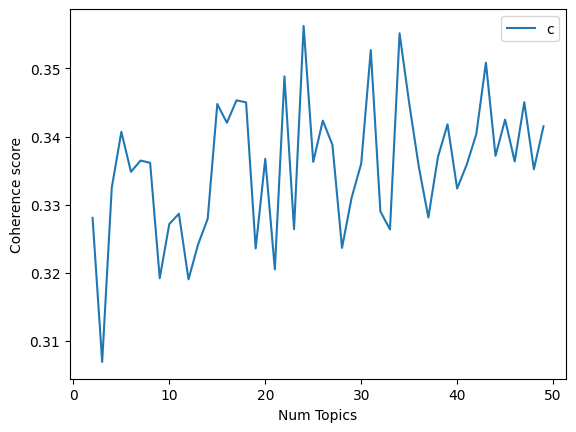

Num Topics = 2  has Coherence Value of 0.3281
Num Topics = 3  has Coherence Value of 0.3069
Num Topics = 4  has Coherence Value of 0.3325
Num Topics = 5  has Coherence Value of 0.3407
Num Topics = 6  has Coherence Value of 0.3348
Num Topics = 7  has Coherence Value of 0.3365
Num Topics = 8  has Coherence Value of 0.3361
Num Topics = 9  has Coherence Value of 0.3192
Num Topics = 10  has Coherence Value of 0.3272
Num Topics = 11  has Coherence Value of 0.3287
Num Topics = 12  has Coherence Value of 0.3191
Num Topics = 13  has Coherence Value of 0.3242
Num Topics = 14  has Coherence Value of 0.3279
Num Topics = 15  has Coherence Value of 0.3448
Num Topics = 16  has Coherence Value of 0.342
Num Topics = 17  has Coherence Value of 0.3453
Num Topics = 18  has Coherence Value of 0.345
Num Topics = 19  has Coherence Value of 0.3236
Num Topics = 20  has Coherence Value of 0.3367
Num Topics = 21  has Coherence Value of 0.3205
Num Topics = 22  has Coherence Value of 0.3488
Num Topics = 23  has Co

In [17]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [29]:
# Select the model and print the topics
optimal_model = model_list[13]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.037*"sil" + 0.024*"berie" + 0.019*"book" + 0.012*"good" + 0.011*"character" + 0.010*"time" + 0.009*"dental" + 0.008*"friend" + 0.007*"section" + 0.007*"moore"'),
 (1,
  '0.041*"book" + 0.029*"great" + 0.013*"story" + 0.010*"study" + 0.009*"good" + 0.009*"berie" + 0.008*"cadaver" + 0.008*"read" + 0.008*"anatomy" + 0.008*"moore"'),
 (2,
  '0.038*"book" + 0.027*"good" + 0.018*"dental" + 0.010*"edition" + 0.010*"textbook" + 0.009*"reader" + 0.009*"exam" + 0.008*"small" + 0.008*"text" + 0.006*"material"'),
 (3,
  '0.069*"book" + 0.026*"good" + 0.024*"dental" + 0.016*"information" + 0.015*"great" + 0.010*"helpful" + 0.008*"practice" + 0.008*"guide" + 0.008*"star" + 0.008*"excellent"'),
 (4,
  '0.066*"book" + 0.014*"page" + 0.013*"test" + 0.013*"good" + 0.012*"structure" + 0.011*"information" + 0.011*"time" + 0.010*"orthodontic" + 0.010*"answer" + 0.010*"great"'),
 (5,
  '0.040*"great" + 0.039*"book" + 0.017*"page" + 0.017*"anatomy" + 0.014*"dental" + 0.014*"helpful" + 0.012*"course

In [30]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.035282  0.012587       1        1  16.810584
8      0.066324  0.061860       2        1  10.547576
12     0.082316 -0.016600       3        1   9.719377
1     -0.063564  0.013318       4        1   8.162351
3      0.003231  0.006709       5        1   7.802012
4      0.010342  0.119707       6        1   7.358372
0     -0.221800 -0.015615       7        1   7.096576
6      0.076802 -0.085032       8        1   6.618642
14     0.032555 -0.003008       9        1   4.974947
5      0.021503  0.098376      10        1   4.664503
13    -0.002831 -0.012960      11        1   4.441322
10    -0.013337  0.022461      12        1   3.897153
2     -0.024242 -0.035147      13        1   3.842676
7      0.038314 -0.125596      14        1   2.654830
9     -0.040896 -0.041061      15        1   1.409079, topic_info=         Term         Freq        Total Category  logprob  loglift
1065      sil    65.000000    65.000000  Default  30.0000  30.0000
134    dental   453.000000   453.000000  Default  29.0000  29.0000
0        book  1251.000000  1251.000000  Default  28.0000  28.0000
71      great   304.000000   304.000000  Default  27.0000  27.0000
47       good   310.000000   310.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
14      money     1.089440    52.701579  Topic15  -5.5002   0.3833
590     tooth     1.056926    30.326402  Topic15  -5.5305   0.9056
18          ™     1.074550    52.276721  Topic15  -5.5139   0.3776
20    anatomy     1.090652   106.822133  Topic15  -5.4991  -0.3222
16       star     1.047539    70.293450  Topic15  -5.5394   0.0560

[1029 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1238      7  0.758823         1970
864       4  0.426687         21st
864       5  0.213343         21st
54        4  0.353346  abomination
1239      4  0.173280     abortion
...     ...       ...          ...
18       11  0.019129            ™
18       12  0.038258            ™
18       13  0.038258            ™
18       14  0.057387            ™
18       15  0.019129            ™

[2686 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 9, 13, 2, 4, 5, 1, 7, 15, 6, 14, 11, 3, 8, 10])